In this collab, we will work to construct our own graph neural network using PyTorch Geometric (PyG) and then apply that model on two Open Graph Benchmark (OGB) datasets. These two datasets will be used to benchmark your model's performance on two different graph-based tasks: 1) node property prediction, predicting properties of single nodes and 2) graph property prediction, predicting properties of entire graphs or subgraphs.

First, we will learn how PyTorch Geometric stores graphs as PyTorch tensors.

Then, we will load and inspect one of the Open Graph Benchmark (OGB) datasets by using the `ogb` package. OGB is a collection of realistic, large-scale, and diverse benchmark datasets for machine learning on graphs. The `ogb` package not only provides data loaders for each dataset but also model evaluators.

Lastly, we will build our own graph neural network using PyTorch Geometric. We will then train and evaluate our model on the OGB node property prediction and graph property prediction tasks.

In [1]:
import torch
import os
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 1.12.0


## Open Graph benchmark(OGB)

The Open Graph Benchmark (OGB) is a collection of realistic, large-scale, and diverse benchmark datasets for machine learning on graphs. Its datasets are automatically downloaded, processed, and split using the OGB Data Loader. The model performance can then be evaluated by using the OGB Evaluator in a unified manner.

We will first perform node-level prediction on the `ogbn-arxiv` dataset.In this section we will build our first graph neural network using PyTorch Geometric. Then we will apply it to the task of node property prediction (node classification).

Specifically, we will use GCN as the foundation for your graph neural network ([Kipf et al. (2017)](https://arxiv.org/pdf/1609.02907.pdf)). To do so, we will work with PyG's built-in `GCNConv` layer.  

## Load and Preprocess the Dataset

In [2]:
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

if 'IS_GRADESCOPE_ENV' not in os.environ:
  dataset_name = 'ogbn-arxiv'
  dataset = PygNodePropPredDataset(name=dataset_name,
                                  transform=T.ToSparseTensor())
  data = dataset[0]

  # Make the adjacency matrix to symmetric
  data.adj_t = data.adj_t.to_symmetric()

  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  # If you use GPU, the device should be cuda
  print('Device: {}'.format(device))

  data = data.to(device)
  split_idx = dataset.get_idx_split()
  train_idx = split_idx['train'].to(device)

Device: cuda


## GCN Model

We will implement the GCN model!

The `forward` function is as shown in the figure.


![test](https://drive.google.com/uc?id=128AuYAXNXGg7PIhJJ7e420DoPWKb-RtL)

In [3]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
               dropout, return_embeds=False):
    super(GCN, self).__init__()
    # We shall define the neural network architecture here that will be important for the forward pass
    self.convs = torch.nn.ModuleList([GCNConv(input_dim, hidden_dim)] +
                                     [GCNConv(hidden_dim, hidden_dim) for _ in range(num_layers-2)] +
                                     [GCNConv(hidden_dim, output_dim)])
    self.bns = torch.nn.ModuleList([torch.nn.BatchNorm1d(hidden_dim) for _ in range(num_layers-1)])
    self.softmax = torch.nn.LogSoftmax(dim=1)
    self.dropout = dropout
    self.return_embeds = return_embeds

  def reset_parameters(self):
    for conv in self.convs:
      conv.reset_parameters()
    for bn in self.bns:
      bn.reset_parameters()
  
  def forward(self, x, adj_t):
    out = None
    for conv, bn in zip(self.convs[:-1], self.bns):
      x = conv(x, adj_t)
      x = bn(x)
      x = F.relu(x)
      x = F.dropout(x,p=self.dropout,training=self.training)
    x = self.convs[-1](x, adj_t)
    out = x if self.return_embeds else self.softmax(x)
    return out

In [4]:
def train(model, data, train_idx, optimizer, loss_fn):
  model.train()
  loss = 0
  
  # 1. First zero the gradient
  optimizer.zero_grad()
  
  # 2. Feed the data into the model
  out = model(data.x, data.adj_t)
  
  # 3. Slice the the model output and label by train_index and feed them to the loss function
  loss = loss_fn(out[train_idx], data.y[train_idx].squeeze())
  
  loss.backward()
  optimizer.step()
  return loss.item()

In [5]:
# Test function here
@torch.no_grad()
def test(model, data, split_idx, evaluator, save_model_results=False):
    # TODO: Implement a function that tests the model by 
    # using the given split_idx and evaluator.
    model.eval()

    # The output of model on all data
    out = None

    ############# Your code here ############
    ## (~1 line of code)
    ## Note:
    ## 1. No index slicing here
    out = model(data.x, data.adj_t)
    #########################################

    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': data.y[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': data.y[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': data.y[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    if save_model_results:
      print ("Saving Model Predictions")

      data = {}
      data['y_pred'] = y_pred.view(-1).cpu().detach().numpy()

      df = pd.DataFrame(data=data)
      # Save locally as csv
      df.to_csv('ogbn-arxiv_node.csv', sep=',', index=False)


    return train_acc, valid_acc, test_acc
  

In [6]:
# Please do not change the args
if 'IS_GRADESCOPE_ENV' not in os.environ:
  args = {
      'device': device,
      'num_layers': 3,
      'hidden_dim': 256,
      'dropout': 0.5,
      'lr': 0.01,
      'epochs': 100,
  }
  args

In [7]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  model = GCN(data.num_features, args['hidden_dim'],
              dataset.num_classes, args['num_layers'],
              args['dropout']).to(device)
  evaluator = Evaluator(name='ogbn-arxiv')

Epoch: 01, Loss: 4.1302, Train: 11.25%, Valid: 23.01% Test: 21.58%
Epoch: 02, Loss: 2.3701, Train: 18.36%, Valid: 19.30% Test: 24.96%
Epoch: 03, Loss: 1.9488, Train: 27.02%, Valid: 24.39% Test: 29.34%
Epoch: 04, Loss: 1.7708, Train: 32.43%, Valid: 22.10% Test: 19.92%
Epoch: 05, Loss: 1.6592, Train: 38.82%, Valid: 31.58% Test: 29.51%
Epoch: 06, Loss: 1.5678, Train: 41.95%, Valid: 35.15% Test: 32.96%
Epoch: 07, Loss: 1.4924, Train: 40.53%, Valid: 34.84% Test: 34.10%
Epoch: 08, Loss: 1.4446, Train: 38.42%, Valid: 37.00% Test: 39.52%
Epoch: 09, Loss: 1.3997, Train: 34.75%, Valid: 33.35% Test: 35.72%
Epoch: 10, Loss: 1.3559, Train: 32.82%, Valid: 28.17% Test: 27.76%
Epoch: 11, Loss: 1.3295, Train: 33.79%, Valid: 28.70% Test: 27.73%
Epoch: 12, Loss: 1.3046, Train: 36.27%, Valid: 33.69% Test: 33.95%
Epoch: 13, Loss: 1.2798, Train: 39.13%, Valid: 38.28% Test: 38.98%
Epoch: 14, Loss: 1.2529, Train: 41.98%, Valid: 41.81% Test: 42.25%
Epoch: 15, Loss: 1.2443, Train: 45.24%, Valid: 45.90% Test: 46

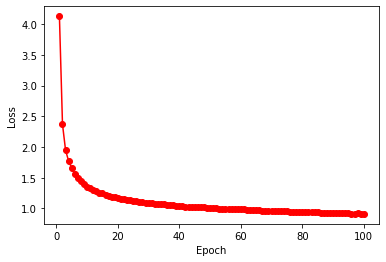

In [8]:
import copy
if 'IS_GRADESCOPE_ENV' not in os.environ:
  # reset the parameters to initial random value
  model.reset_parameters()

  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
  loss_fn = F.nll_loss

  best_model = None
  best_valid_acc = 0
  
  epochs = []
  losses = []
  for epoch in range(1, 1 + args["epochs"]):
    loss = train(model, data, train_idx, optimizer, loss_fn)
    result = test(model, data, split_idx, evaluator)
    train_acc, valid_acc, test_acc = result
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model = copy.deepcopy(model)
    
    epochs.append(epoch)
    losses.append(loss)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')

  import matplotlib.pyplot as plt
  plt.plot(epochs, losses, '-ro')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

## GNN: Graph Property Prediction

In this section we will create a graph neural network for graph property prediction (graph classification). We will do this on the ogbf-molhiv dataset.

## Load and preprocess the dataset

In [9]:
from ogb.graphproppred import PygGraphPropPredDataset, Evaluator
from torch_geometric.data import DataLoader
from tqdm.notebook import tqdm

if 'IS_GRADESCOPE_ENV' not in os.environ:
  # Load the dataset 
  dataset = PygGraphPropPredDataset(name='ogbg-molhiv')

  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  print('Device: {}'.format(device))

  split_idx = dataset.get_idx_split()

  # Check task type
  print('Task type: {}'.format(dataset.task_type))

# Load the dataset splits into corresponding dataloaders
# We will train the graph classification task on a batch of 32 graphs
# Shuffle the order of graphs for training set
if 'IS_GRADESCOPE_ENV' not in os.environ:
  train_loader = DataLoader(dataset[split_idx["train"]], batch_size=32, shuffle=True, num_workers=0)
  valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=32, shuffle=False, num_workers=0)
  test_loader = DataLoader(dataset[split_idx["test"]], batch_size=32, shuffle=False, num_workers=0)

if 'IS_GRADESCOPE_ENV' not in os.environ:
  # Please do not change the args
  args = {
      'device': device,
      'num_layers': 5,
      'hidden_dim': 256,
      'dropout': 0.5,
      'lr': 0.001,
      'epochs': 30,
  }
  args

Device: cuda
Task type: binary classification


C:\Users\tktan\anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### Graph Mini-Batching
Before diving into the actual model, we introduce the concept of mini-batching with graphs. In order to parallelize the processing of a mini-batch of graphs, PyG combines the graphs into a single disconnected graph data object (*torch_geometric.data.Batch*). *torch_geometric.data.Batch* inherits from *torch_geometric.data.Data* (introduced earlier) and contains an additional attribute called `batch`. 

The `batch` attribute is a vector mapping each node to the index of its corresponding graph within the mini-batch:

    batch = [0, ..., 0, 1, ..., n - 2, n - 1, ..., n - 1]

This attribute is crucial for associating which graph each node belongs to and can be used to e.g. average the node embeddings for each graph individually to compute graph level embeddings. 

### Implemention
Now, we have all of the tools to implement a GCN Graph Prediction model!  

We will reuse the existing GCN model to generate `node_embeddings` and then use  `Global Pooling` over the nodes to create graph level embeddings that can be used to predict properties for the each graph. Remeber that the `batch` attribute will be essential for performining Global Pooling over our mini-batch of graphs.

In [10]:
from ogb.graphproppred.mol_encoder import AtomEncoder
from torch_geometric.nn import global_add_pool, global_mean_pool

### GCN to predict graph property
class GCN_Graph(torch.nn.Module):
    def __init__(self, hidden_dim, output_dim, num_layers, dropout):
        super(GCN_Graph, self).__init__()

        # Load encoders for Atoms in molecule graphs
        self.node_encoder = AtomEncoder(hidden_dim)

        # Node embedding model
        # Note that the input_dim and output_dim are set to hidden_dim
        self.gnn_node = GCN(hidden_dim, hidden_dim,
            hidden_dim, num_layers, dropout, return_embeds=True)

        self.pool = None

        ############# Your code here ############
        ## Note:
        ## 1. Initialize self.pool as a global mean pooling layer
        ## For more information please refer to the documentation:
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#global-pooling-layers
        self.pool = global_mean_pool
        #########################################

        # Output layer
        self.linear = torch.nn.Linear(hidden_dim, output_dim)


    def reset_parameters(self):
      self.gnn_node.reset_parameters()
      self.linear.reset_parameters()

    def forward(self, batched_data):
        # TODO: Implement a function that takes as input a 
        # mini-batch of graphs (torch_geometric.data.Batch) and 
        # returns the predicted graph property for each graph. 
        #
        # NOTE: Since we are predicting graph level properties,
        # your output will be a tensor with dimension equaling
        # the number of graphs in the mini-batch

    
        # Extract important attributes of our mini-batch
        x, edge_index, batch = batched_data.x, batched_data.edge_index, batched_data.batch
        embed = self.node_encoder(x)

        out = None

        ############# Your code here ############
        ## Note:
        ## 1. Construct node embeddings using existing GCN model
        ## 2. Use the global pooling layer to aggregate features for each individual graph
        ## For more information please refer to the documentation:
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#global-pooling-layers
        ## 3. Use a linear layer to predict each graph's property
        ## (~3 lines of code)
        embed = self.gnn_node(embed, edge_index)
        features = self.pool(embed, batch)
        out = self.linear(features)
        #########################################

        return out

In [11]:
def train(model, device, data_loader, optimizer, loss_fn):
    # TODO: Implement a function that trains your model by 
    # using the given optimizer and loss_fn.
    model.train()
    loss = 0

    for step, batch in enumerate(tqdm(data_loader, desc="Iteration")):
      batch = batch.to(device)

      if batch.x.shape[0] == 1 or batch.batch[-1] == 0:
          pass
      else:
        ## ignore nan targets (unlabeled) when computing training loss.
        is_labeled = batch.y == batch.y

        ############# Your code here ############
        ## Note:
        ## 1. Zero grad the optimizer
        ## 2. Feed the data into the model
        ## 3. Use `is_labeled` mask to filter output and labels
        ## 4. You may need to change the type of label to torch.float32
        ## 5. Feed the output and label to the loss_fn
        ## (~3 lines of code)
        optimizer.zero_grad()
        out = model(batch)
        loss = loss_fn(out[is_labeled], batch.y[is_labeled].float())
        #########################################

        loss.backward()
        optimizer.step()

    return loss.item()

In [12]:
# The evaluation function
def eval(model, device, loader, evaluator, save_model_results=False, save_file=None):
    model.eval()
    y_true = []
    y_pred = []

    for step, batch in enumerate(tqdm(loader, desc="Iteration")):
        batch = batch.to(device)

        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred = model(batch)

            y_true.append(batch.y.view(pred.shape).detach().cpu())
            y_pred.append(pred.detach().cpu())

    y_true = torch.cat(y_true, dim = 0).numpy()
    y_pred = torch.cat(y_pred, dim = 0).numpy()

    input_dict = {"y_true": y_true, "y_pred": y_pred}

    if save_model_results:
        print ("Saving Model Predictions")
        
        # Create a pandas dataframe with a two columns
        # y_pred | y_true
        data = {}
        data['y_pred'] = y_pred.reshape(-1)
        data['y_true'] = y_true.reshape(-1)

        df = pd.DataFrame(data=data)
        # Save to csv
        df.to_csv('ogbg-molhiv_graph_' + save_file + '.csv', sep=',', index=False)

    return evaluator.eval(input_dict)

In [13]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  model = GCN_Graph(args['hidden_dim'],
              dataset.num_tasks, args['num_layers'],
              args['dropout']).to(device)
  evaluator = Evaluator(name='ogbg-molhiv')

Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 01, Loss: 0.0314, Train: 72.08%, Valid: 73.31% Test: 68.88%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 02, Loss: 0.8307, Train: 72.11%, Valid: 71.27% Test: 70.43%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 03, Loss: 0.0429, Train: 76.70%, Valid: 75.01% Test: 73.38%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 04, Loss: 0.0393, Train: 76.45%, Valid: 73.91% Test: 72.24%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 05, Loss: 0.0389, Train: 77.72%, Valid: 77.89% Test: 72.51%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 06, Loss: 0.0308, Train: 78.84%, Valid: 78.30% Test: 71.88%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 07, Loss: 0.0113, Train: 79.11%, Valid: 77.31% Test: 71.97%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 08, Loss: 0.6517, Train: 77.40%, Valid: 72.66% Test: 70.63%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 09, Loss: 0.0460, Train: 79.32%, Valid: 75.99% Test: 70.90%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.0396, Train: 79.13%, Valid: 77.32% Test: 70.60%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 11, Loss: 0.0247, Train: 79.82%, Valid: 73.32% Test: 72.13%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 12, Loss: 0.0354, Train: 79.50%, Valid: 74.23% Test: 72.21%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 13, Loss: 0.7367, Train: 79.76%, Valid: 76.84% Test: 72.17%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 14, Loss: 0.0320, Train: 80.50%, Valid: 74.84% Test: 68.53%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 15, Loss: 0.0299, Train: 80.92%, Valid: 75.72% Test: 71.60%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 16, Loss: 0.0258, Train: 82.00%, Valid: 76.21% Test: 72.49%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 17, Loss: 0.0320, Train: 82.07%, Valid: 72.12% Test: 70.86%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 18, Loss: 0.7075, Train: 81.92%, Valid: 76.97% Test: 71.98%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 19, Loss: 0.0317, Train: 82.24%, Valid: 76.54% Test: 73.55%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 20, Loss: 0.0481, Train: 81.65%, Valid: 76.48% Test: 72.68%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 21, Loss: 0.6243, Train: 82.33%, Valid: 76.52% Test: 73.54%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 22, Loss: 0.0262, Train: 82.71%, Valid: 77.10% Test: 73.86%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 23, Loss: 0.0397, Train: 82.94%, Valid: 77.33% Test: 74.09%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 24, Loss: 0.0185, Train: 82.95%, Valid: 78.81% Test: 75.63%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 25, Loss: 0.0224, Train: 82.40%, Valid: 77.01% Test: 75.07%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 26, Loss: 0.0261, Train: 83.49%, Valid: 77.93% Test: 73.41%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 27, Loss: 0.3908, Train: 82.89%, Valid: 79.30% Test: 73.11%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 28, Loss: 0.0111, Train: 83.59%, Valid: 77.73% Test: 75.30%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 29, Loss: 0.0275, Train: 83.62%, Valid: 74.99% Test: 75.29%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 30, Loss: 0.0385, Train: 83.53%, Valid: 79.22% Test: 75.69%


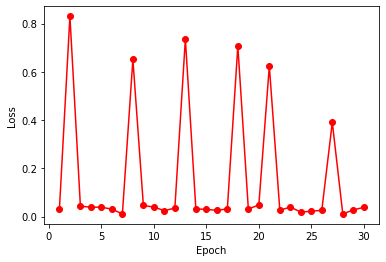

In [14]:
import copy

if 'IS_GRADESCOPE_ENV' not in os.environ:
  model.reset_parameters()

  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
  loss_fn = torch.nn.BCEWithLogitsLoss()

  best_model = None
  best_valid_acc = 0
  
  epochs = []
  losses = []
  for epoch in range(1, 1 + args["epochs"]):
    print('Training...')
    loss = train(model, device, train_loader, optimizer, loss_fn)

    print('Evaluating...')
    train_result = eval(model, device, train_loader, evaluator)
    val_result = eval(model, device, valid_loader, evaluator)
    test_result = eval(model, device, test_loader, evaluator)

    train_acc, valid_acc, test_acc = train_result[dataset.eval_metric], val_result[dataset.eval_metric], test_result[dataset.eval_metric]
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model = copy.deepcopy(model)
    epochs.append(epoch)
    losses.append(loss)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')

  import matplotlib.pyplot as plt
  plt.plot(epochs, losses, '-ro')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

In [15]:
train_acc = eval(best_model, device, train_loader, evaluator)[dataset.eval_metric]
valid_acc = eval(best_model, device, valid_loader, evaluator)[dataset.eval_metric]
test_acc = eval(best_model, device, test_loader, evaluator)[dataset.eval_metric]

print(f'Best model: '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Best model: Train: 82.89%, Valid: 79.30% Test: 73.11%
